In [1]:
# %load ./include/header.py
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import trange,tqdm
sys.path.append('./include')
import ml4s
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('./include/notebook.mplstyle')
np.set_printoptions(linewidth=120)
ml4s._set_css_style('./include/bootstrap.css')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
import cv2
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
import random

# 3

In [2]:
web = plt.imread('/lustre/haven/proj/UTK0154/data/mcm41_reduced.png')

In [3]:
def normalize(pic):
    maxval = np.amax(pic)
    minval = np.amin(pic)
    pic -= minval
    pic *= 1./(maxval-minval)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


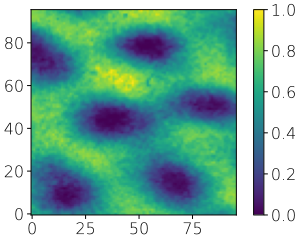

In [4]:
normalize(web)
plt.imshow(web, origin='lower')
plt.colorbar()

In [5]:
x0max,x1max =np.shape(web)

def target(_x0,_x1):
    _x0 = (x0max-1.)*_x0
    _x1 = (x1max-1.)*_x1
    i_x0 = _x0.astype(int)
    i_x1 = _x1.astype(int)
    return web[i_x0,i_x1]

In [6]:
grid_size = 48
X = np.meshgrid(np.linspace(0,1,grid_size),np.linspace(0,1,grid_size), indexing='ij')
batch_size = grid_size**2
aₒ = np.zeros([batch_size,2])
aₒ[:,0] = X[0].flatten()
aₒ[:,1] = X[1].flatten()
Ytest = target(aₒ[:,0],aₒ[:,1])

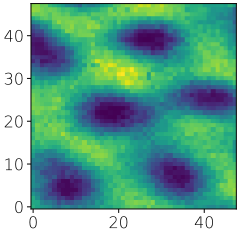

In [7]:
plt.imshow(Ytest.reshape(grid_size,grid_size), origin='lower')

In [8]:
from scipy.special import expit as sigmoid
def ffprime(z):
    '''calculate f(z) and f'(z); sigmoid.'''
    _f = sigmoid(z)
    return _f,_f * (1.0-_f)

def feed_forward(aₒ,w,b):
    '''Propagate an input vector x = aₒ through 
       a network with weights (w) and biases (b).
       Return: activations (a) and derivatives f'(z).'''
    
    a,df = [aₒ],[]
    for wℓ,bℓ in zip(w,b):
        zℓ = np.dot(a[-1],wℓ) + bℓ
        _a,_df = ffprime(zℓ)
        a.append(_a)
        df.append(_df)
        
    return a,df
def backpropagation(y,a,w,b,df): 
    '''Inputs: results of a forward pass
       Targets     y: dim(y)  = batch_size ⨯ nL
       Activations a: dim(a)  = L ⨯ batch_size ⨯ nℓ
       Weights     w: dim(w)  = L-1 ⨯ nℓ₋₁ ⨯ nℓ
       Biases      b: dim(b)  = L-1 ⨯ nℓ
       f'(z)      df: dim(df) = L-1 ⨯ batch_size ⨯ nℓ
       
       Outputs: returns mini-batch averaged gradients of the cost function w.r.t. w and b
       dC_dw: dim(dC_dw) = dim(w)
       dC_db: dim(dC_db) = dim(b)
    '''
    
    num_layers = len(w)
    L = num_layers-1        
    batch_size = len(y)
    
    # initialize empty lists to store the derivatives of the cost functions
    dC_dw = [None]*num_layers
    dC_db = [None]*num_layers
    Δ = [None]*num_layers
    
    # perform the backpropagation
    for ℓ in reversed(range(num_layers)):
        
        # treat the last layer differently
        if ℓ == L:
            Δ[ℓ] = (a[ℓ] - y)*df[ℓ]
        else: 
            Δ[ℓ] = (Δ[ℓ+1] @ w[ℓ+1].T) * df[ℓ]
            
        dC_dw[ℓ] = (a[ℓ-1].T @ Δ[ℓ]) / batch_size
        dC_db[ℓ] = np.average(Δ[ℓ],axis=0)
        
    return dC_dw,dC_db

def gradient_step(η,w,b,dC_dw,dC_db):
    '''Update the weights and biases as per gradient descent.'''
    
    for ℓ in range(len(w)):
        w[ℓ] -= η*dC_dw[ℓ]
        b[ℓ] -= η*dC_db[ℓ]
    return w,b

def train_network(x,y,w,b,η):
    '''Train a deep neural network via feed forward and back propagation.
       Inputs:
       Input         x: dim(x) = batch_size ⨯ n₁
       Target        y: dim(y) = batch_size ⨯ nL
       Weights       w: dim(w)  = L-1 ⨯ nℓ₋₁ ⨯ nℓ
       Biases        b: dim(b)  = L-1 ⨯ nℓ
       Learning rate η
       
       Outputs: the least squared cost between the network output and the targets.
       '''
    
    a,df = feed_forward(x,w,b)
    
    # we pass a cycled a by 1 layer for ease of indexing
    dC_dw,dC_db = backpropagation(y,a[1:]+[a[0]],w,b,df)
    
    w,b = gradient_step(η,w,b,dC_dw,dC_db)
    
    return 0.5*np.average((y-a[-1])**2)
def make_batch(n,batch_size,extent,func):
    '''Create a mini-batch from our inputs and outputs.
    Inputs:
    n0        : number of neurons in each layer
    batch_size: the desired number of samples in the mini-batch
    extent    : [min(xₒ),max(xₒ), min(x₁),max(x₁),…,min(x_{n[0]-1}),max(x_{n[0]-1})]
    func:     : the desired target function.
    
    Outputs: returns the desired mini-batch of inputs and targets.
    '''
    
    x = np.zeros([batch_size,n[0]])
    for i in range(n[0]):
        x[:,i] = np.random.uniform(low=0.0,high=1.0,size=[batch_size])
    
    
    y = func(*[x[:,j] for j in range(n[0])]).reshape(-1,n[-1])
    
    return x,y 
def feed_forward_simple(aₒ,w,b):
    '''Propagate an input vector x = aₒ through 
       a network with weights (w) and biases (b). '''
    a = aₒ
    for wℓ,bℓ in zip(w,b):
        z = np.dot(a,wℓ) + bℓ
        
        # using a sigmoid for non-linearity
        a = 1.0/(1.0+np.exp(-z))
    return a

In [15]:
extent = [0., 1.0, 0., 1.0]
n = [2,100,100,100,1]
w,b = [],[]
for ℓ in range(len(n)-1):
    w.append(np.random.uniform(low=-5,high=5, size=(n[ℓ],n[ℓ+1])))
    b.append(np.random.uniform(low=-1,high=1, size=n[ℓ+1]))

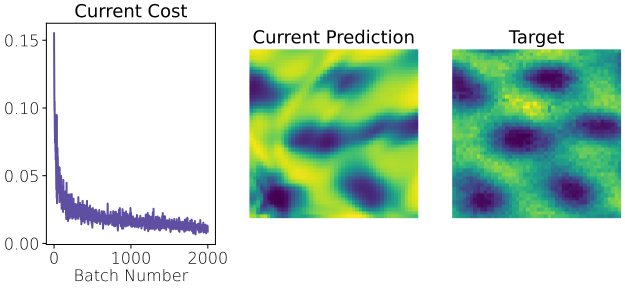

In [16]:
from IPython.display import clear_output,display

η = 0.9

batch_size = 500
num_steps = 2000
plot_ratio = int(num_steps / 50)

w_best, b_best = [],[]
cost_best = 10000.

costs = np.zeros(num_steps)
for j in range(num_steps):
    
    x,y = make_batch(n,batch_size,extent,target)

    costs[j] = train_network(x,y,w,b,η)
    if (costs[j]<cost_best):
        cost_best=costs[j]
        w_best = np.array(w,copy=True)
        b_best = np.array(b,copy=True)
    # we plot every plot_ratio steps
    if not j % plot_ratio or j == num_steps-1:
        
        clear_output(wait=True)
        ret = feed_forward(aₒ,w,b)
        aL = ret[0][-1].reshape(grid_size,grid_size)#feed_forward_simple(aₒ,w,b).reshape(grid_size,grid_size)
        fig,ax = plt.subplots(ncols=3,nrows=1,figsize=(10,4))
        
        ax[1].axis('off')
        img = ax[1].imshow(aL, extent=extent, origin='lower', interpolation = 'nearest', aspect='equal')
        
        ax[2].axis('off')
        ax[2].imshow(Ytest.reshape(grid_size,grid_size), origin='lower',interpolation='nearest', aspect='equal',vmin=0, vmax=1)

        ax[0].plot(costs)

        ax[0].set_title("Current Cost")
        ax[0].set_xlabel("Batch Number")
        ax[1].set_title("Current Prediction")
        ax[2].set_title("Target")

        plt.show()

# 4

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import datetime

In [18]:
def lorent(A,mu,sig,x):
    return A/(((x-mu)**2/sig**2)+1)

def gauss(A,mu,sig,x):
    return A*np.exp(-(x-mu)**2/(2*(sig**2)))

In [19]:
def rand_lorent(Amax,mu_val,sig_max,xmin,xmax, num):
    ran = np.zeros(num)
    X = np.linspace(xmin,xmax,num)
    A = np.random.uniform(low=Amax*0.1,high=Amax)
    mu = np.random.uniform(low=xmin+abs(mu_val),high=xmax-abs(mu_val))
    sig = np.random.uniform(low=sig_max*0.1,high=sig_max)
    return lorent(A,mu,sig,X)

def rand_gauss(Amax,mu_val,sig_max,xmin,xmax,num):
    ran = np.zeros(num)
    X = np.linspace(xmin,xmax,num)
    A = np.random.uniform(low=Amax*0.1,high=Amax)
    mu = np.random.uniform(low=xmin+abs(mu_val),high=xmax-abs(mu_val))
    sig = np.random.uniform(low=sig_max*0.1,high=sig_max)
    return gauss(A,mu,sig,X)

In [20]:
def makedataset(distros,prob_gauss,xmin,xmax,num):
    Amax = 1.0
    mu_val = 1.0
    sig_max = 1.0
    X = np.linspace(xmin,xmax,num)
    classes = np.zeros(distros)
    Y = np.zeros((distros,num))
    for i in range(distros):
        rnd = np.random.uniform(low=0.,high=1.)
        if (rnd < prob_gauss):
            classes[i] = 1
            Y[i,:] = rand_gauss(Amax,mu_val,sig_max,xmin,xmax,num)
        else:
            classes[i] = 0
            Y[i,:] = rand_lorent(Amax,mu_val,sig_max,xmin,xmax,num)
    return Y,classes

In [21]:
points = 200
distros = 1000
gauss_ratio = 0.5
x_low = -5
x_high = 5

X,Y = makedataset(distros,gauss_ratio,x_low,x_high,points)

from sklearn.model_selection import train_test_split
x_train1, x_test1, y_train1, y_test1 = train_test_split(X, Y, test_size=0.999)
x_train2, x_test2, y_train2, y_test2 = train_test_split(X, Y, test_size=0.99)
x_train3, x_test3, y_train3, y_test3 = train_test_split(X, Y, test_size=0.9)

# B

In [34]:
model = keras.Sequential(
[
    layers.Dense(100,input_shape=(points,),activation='relu'),
    layers.Dense(50,activation='relu'),
    layers.Dense(100,activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
# model.summary()
model.compile(loss=keras.losses.binary_crossentropy, optimizer='adam', metrics=['accuracy'])

In [35]:
batch_size = 10
epochs = 30
training_1 = {}
training_1['test'] = model.fit(x_train1,y_train1, epochs=epochs,validation_data=(x_test1,y_test1), verbose=0)

batch_size = 20
epochs = 30
training_2 = {}
training_2['test'] = model.fit(x_train2,y_train2, epochs=epochs,validation_data=(x_test2,y_test2), verbose=0)

batch_size = 100
epochs = 30
training_3 = {}
training_3['test'] = model.fit(x_train3,y_train3, epochs=epochs,validation_data=(x_test3,y_test3), verbose=0)

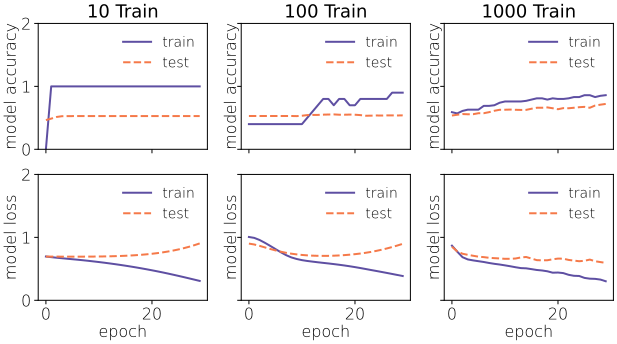

In [36]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig,ax = plt.subplots(2,3, sharex=True, sharey=True, figsize=(10,5))

# training 1
ax[0,0].plot(training_1['test'].history['accuracy'])
ax[0,0].plot(training_1['test'].history['val_accuracy'], ls='--', color=colors[-3])
ax[0,0].set_ylabel('model accuracy')
ax[0,0].legend(['train', 'test'], loc='best')
ax[0,0].set_title("10 Train")
ax[0,0].set_ylim(0,2)

ax[1,0].plot(training_1['test'].history['loss'])
ax[1,0].plot(training_1['test'].history['val_loss'], ls='--', color=colors[-3])
ax[1,0].set_ylabel('model loss')
ax[1,0].set_xlabel('epoch')
ax[1,0].legend(['train', 'test'], loc='best')

# training 2
ax[0,1].plot(training_2['test'].history['accuracy'])
ax[0,1].plot(training_2['test'].history['val_accuracy'], ls='--', color=colors[-3])
ax[0,1].set_ylabel('model accuracy')
ax[0,1].legend(['train', 'test'], loc='best')
ax[0,1].set_title("100 Train")
ax[0,1].set_ylim(0,2)

ax[1,1].plot(training_2['test'].history['loss'])
ax[1,1].plot(training_2['test'].history['val_loss'], ls='--', color=colors[-3])
ax[1,1].set_ylabel('model loss')
ax[1,1].set_xlabel('epoch')
ax[1,1].legend(['train', 'test'], loc='best')

#training 3
ax[0,2].plot(training_3['test'].history['accuracy'])
ax[0,2].plot(training_3['test'].history['val_accuracy'], ls='--', color=colors[-3])
ax[0,2].set_ylabel('model accuracy')
ax[0,2].legend(['train', 'test'], loc='best')
ax[0,2].set_title("1000 Train")
ax[0,2].set_ylim(0,2)

ax[1,2].plot(training_3['test'].history['loss'])
ax[1,2].plot(training_3['test'].history['val_loss'], ls='--', color=colors[-3])
ax[1,2].set_ylabel('model loss')
ax[1,2].set_xlabel('epoch')
ax[1,2].legend(['train', 'test'], loc='best');

In [37]:
score = model.evaluate(x_test3, y_test3, verbose=2)

predictions = np.zeros(X.shape[0],dtype=int)
predictions[np.where(model(X)>=0.5)[0]] = 1

mistakes = np.where(Y != predictions)[0]
num_mistakes = len(mistakes)

print(f'Num. Mistakes = {num_mistakes} of 9000,',round(100*num_mistakes/9000,1),"%")

29/29 - 0s - loss: 0.5944 - accuracy: 0.7211
Num. Mistakes = 264 of 9000, 2.9 %
